## Beam problem: Eigenvalue method

### Dependencies

In [1]:
from meshes import *
from Eigenvalues import *
from NumericalSolutions import *
from get_S import *
from get_M import *

import matplotlib.pyplot as plt
import numpy as np


"""
For the widgets to show up, do the following in the anaconda prompt:

conda install -c conda-forge ipywidgets
jupyter labextension install @jupyter-widgets/jupyterlab-manager
"""
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual

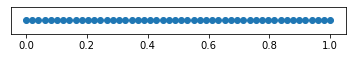

In [4]:
# Spatial resolution of mesh
N = 50

# Right limit of mesh
L = 1

# Generate 1D mesh
[nodes, elems, faces] = get_mesh_1D(N, [0,L], True);
elems = np.array(elems)   

In [5]:
E=1
I=1
mu_const = 1    
two_sided_support = False

In [6]:
### ----- Problem parameters (only used for initial solution) ------ ###

M0 = 0
ML = 0
QL = 0
a0 = 0
aL = 0
a = 0
b = 0

q = 1

In [7]:
### ----- Get initial solution as solution to static problem ----- ###
if two_sided_support:
    
    boundary_conditions = {'M0': M0, 'ML': ML, 'a0': a0, 'aL': aL}

    # Do numerical solution
    sol_num = NumericalSolutionBothEnds(ML=ML, M0=M0, a0=a0, aL=aL, E=E, I=I, N=N, L=L, q=q)
    w_num, wp_num = sol_num.solve()

else:
    
    boundary_conditions = {'QL': QL, 'ML': ML, 'a': a, 'b': b}
        
    # Do numerical solution
    sol_num = NumericalSolutionCantilever(a=a, b=b, QL=QL, ML=ML, E=E, I=I, N=N, L=L, q=q)
    w_num, wp_num = sol_num.solve()

In [80]:
# Get matrices
M_ext = get_extended_M(nodes, elems, mu_const)
S_ext = get_extended_S(nodes, elems, E, I, two_sided_support)
M = get_M_global(nodes, elems, mu_const)

# Create time array
T = 10   # end time
Nt = 200 # time step size
times = np.linspace(0, T, Nt)

# Initial values
w_init = np.zeros(np.shape(M)[0])
wp_init = np.zeros(np.shape(M)[0])
#w_init = np.power(np.linspace(0,1,np.shape(M)[0]),2)

# Create solution object
sol_eigen = Eigenvalues(w0=np.ravel([w_num,wp_num],'F'), wp0=wp_init, M=M, Me=M_ext, Se=S_ext)

# Get transient solutions (w[:, k] should be solution at time step k etc.) 
w, mu = sol_eigen.solver(times)

# Get solution in time step k

#k = 20
#wk = w[::2, k]
#wk = w[1::2, k]
#plt.figure()
#plt.plot(nodes, wk)
#plt.show()

# TODO: use static case for w_init, and wp_init


[1.16812883e-12 6.90616607e-11 6.97180518e-11 7.08271291e-11
 7.24269390e-11 7.43647730e-11 7.68469627e-11 7.98123010e-11
 8.34639713e-11 8.73040796e-11 9.14372592e-11 9.64679887e-11
 1.02538419e-10 1.08075496e-10 1.15050568e-10 1.22958017e-10
 1.30797200e-10 1.38982518e-10 1.49609662e-10 1.59249205e-10
 1.70630680e-10 1.82868320e-10 1.97357906e-10 2.10905595e-10
 2.27523151e-10 2.44164586e-10 2.62072344e-10 2.83260834e-10
 3.02606565e-10 3.28375015e-10 3.53723955e-10 3.80003681e-10
 4.11393712e-10 4.42390474e-10 4.78533083e-10 5.16359089e-10
 5.56193952e-10 6.04527274e-10 6.51486264e-10 7.05946339e-10
 7.64670412e-10 8.27274802e-10 8.98136599e-10 9.73592851e-10
 1.05548546e-09 1.14379748e-09 1.23730228e-09 1.33122378e-09
 1.41130950e-09 1.79606205e-09 1.90518693e-09 2.05862546e-09
 2.24324287e-09 2.45608105e-09 2.69795746e-09 2.97228842e-09
 3.28172494e-09 3.63152670e-09 4.03018767e-09 4.48131273e-09
 4.99769541e-09 5.58772724e-09 6.26372764e-09 7.04482956e-09
 7.94669107e-09 8.995180

In [60]:
#u = results["u"]

def sol_step(u, i):
    """ 
    Function to separate derivative and solution 
    """
    u = u[:, i]
    #u = u[:-2]
    ux = u[::2]
    
    return ux

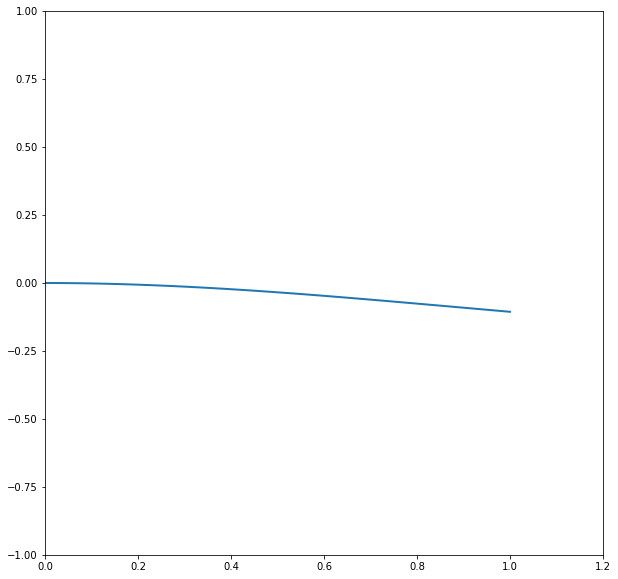

In [61]:
# get animations

%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlim(( 0, 1.2))
ax.set_ylim((-1,1))
# try: ax.set_ylim((np.min(-u[nsteps-1][:-2][::2]), np.max(u[nsteps-1][:-2][::2])))
# except: ax.set_ylim((np.min(-solution), np.max(solution)))
        
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    line.set_data(nodes, sol_step(w, i))
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nt, interval=10, 
                               blit=True)
HTML(anim.to_jshtml())